# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'datasets/train.p'
testing_file = 'datasets/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

### Step 0.1: construct the class lookup table

In [2]:
import pandas as pd
sign_lookup = pd.read_csv('signnames.csv')

In [3]:
sign_lookup

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


In [4]:
sign_lookup.loc[0]['SignName']

'Speed limit (20km/h)'

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

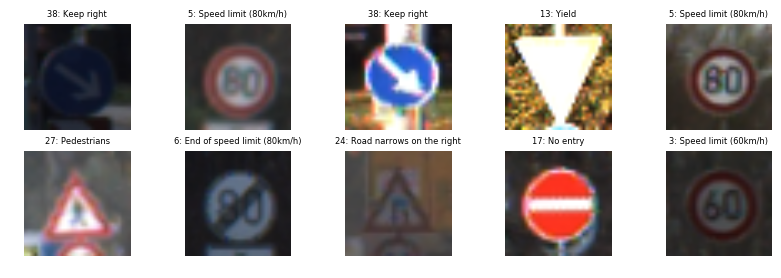

In [5]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

fig, axs = plt.subplots(2,5, figsize=(10, 3))
axs = axs.ravel()
plt.rc('font', size=5)
for i in range(10):
    index = random.randint(0, len(X_train))
    image = X_train[index].squeeze()
    axs[i].axis('off')
    axs[i].imshow(image, cmap='gray')
    axs[i].set_title("{}: {}".format(y_train[index], sign_lookup.loc[y_train[index]]['SignName']))

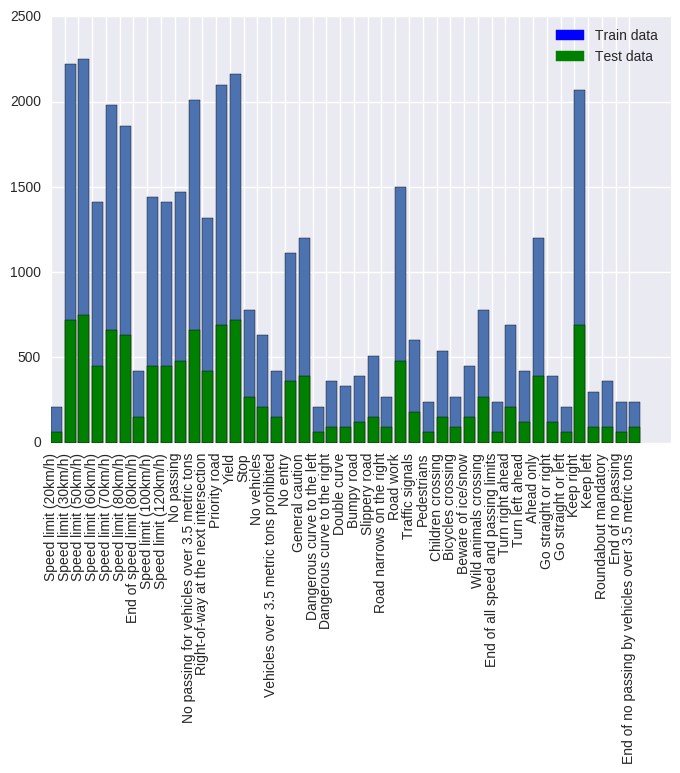

In [6]:
from collections import Counter
import matplotlib.patches as mpatches
import seaborn as sns

c = Counter(y_train)
c2 = Counter(y_test)

plt.bar(list(c.keys()),list(c.values()))
plt.bar(list(c2.keys()),list(c2.values()),color='green')
blue_patch = mpatches.Patch(color='blue', label='Train data')
green_patch = mpatches.Patch(color='green', label='Test data')
plt.xticks(list(c.keys()), sign_lookup['SignName'],rotation='90')
plt.legend(handles=[blue_patch,green_patch])

The dataset is imbalanced in term of classes though, it might be a good idea to generate data that is lower than 900

In [7]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = image.shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(sign_lookup)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

#### Preprocessing idea
- If the images are not very bright, pre-processing techniques like histogram equalization can help
 - Compare Adaptive & normal histrogram EQ
- Some other techniques are mean subtraction and standard deviation scaling of the input data
 - uses z-score
- More preprocessing steps could have been included
- This resource might provide some more intuition on the subjec

In [8]:
from scipy import stats
from skimage import exposure
from tqdm import tqdm

# This function taken from
# http://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python
def rgb2gray(rgb):
    return np.array(np.dot(rgb[...,:3], [0.299, 0.587, 0.114]), dtype=np.uint8)

def image_histogram_equalization(image, number_bins=256):
    # from http://www.janeriksolem.net/2009/06/histogram-equalization-with-python-and.html
    # from http://stackoverflow.com/questions/28518684/histogram-equalization-of-grayscale-images-with-numpy
    
    # get image histogram
    image_histogram, bins = np.histogram(image.flatten(), number_bins, normed=True)
    cdf = image_histogram.cumsum() # cumulative distribution function
    cdf = 255 * cdf / cdf[-1] # normalize

    # use linear interpolation of cdf to find new pixel values
    image_equalized = np.interp(image.flatten(), bins[:-1], cdf)
    return image_equalized.reshape(image.shape), cdf

In [9]:
X_train_gray = rgb2gray(X_train)
X_test_gray = rgb2gray(X_test)

X_train_eq = np.zeros(X_train_gray.shape)
X_test_eq = np.zeros(X_test_gray.shape)
print(X_train_gray.shape)
print(X_train_eq.shape)

for i in tqdm(range(X_train_gray.shape[0])):
    X_train_eq[i] = exposure.equalize_adapthist(X_train_gray[i])
    
for i in tqdm(range(X_test_gray.shape[0])):
    X_test_eq[i] = exposure.equalize_adapthist(X_test_gray[i])
    
X_train_eq_simple = image_histogram_equalization(X_train_gray)[0]
X_test_eq_simple = image_histogram_equalization(X_test_gray)[0]

  0%|          | 20/39209 [00:00<03:16, 199.04it/s]

(39209, 32, 32)
(39209, 32, 32)


100%|██████████| 12630/12630 [01:03<00:00, 197.93it/s]


### Visualization between Adaptive Histrogram Equalization and normal Histrogram equalization

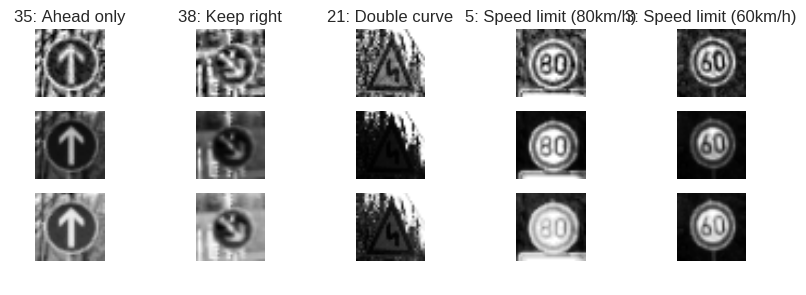

In [11]:
fig, axs = plt.subplots(3,5, figsize=(10, 3))
axs = axs.ravel()
plt.rc('font', size=5)
for i in range(5):
    index = random.randint(0, len(X_train_eq))
    image = X_train_eq[index].squeeze()
    axs[i].axis('off')
    axs[i].imshow(image, cmap='gray')
    axs[i].set_title("{}: {}".format(y_train[index], sign_lookup.loc[y_train[index]]['SignName']))
    
    image = X_train_gray[index].squeeze()
    axs[i+5].axis('off')
    axs[i+5].imshow(image, cmap='gray')
    
    image = X_train_eq_simple[index].squeeze()
    axs[i+10].axis('off')
    axs[i+10].imshow(image, cmap='gray')

### It seems normal histrogram equalization is better, let's take this one

In [12]:
X_train_normalized = stats.zscore(X_train_eq_simple)
X_test_normalized = stats.zscore(X_test_eq_simple)

### now, let's take care of those imbalanced classes, let's generate!

In [13]:
class_counter = Counter(y_train)

In [14]:
need_gen = [i for i in range(43) if np.array(list(class_counter.values()))[i] < 900]

## Warp testing

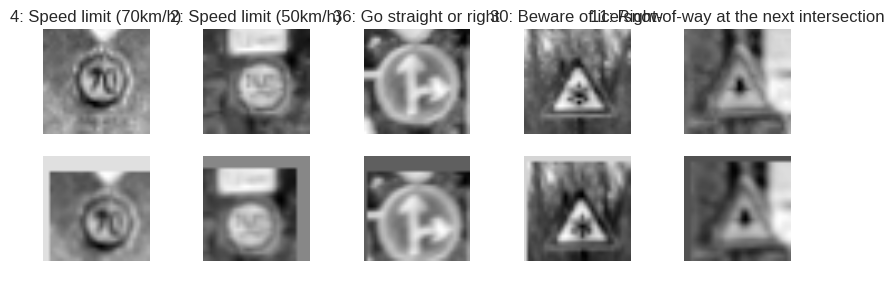

In [17]:
from skimage.transform import rotate, warp

def random_shift(xy):
    xy[:, 0] += np.random.uniform(-5,5)
    xy[:, 1] += np.random.uniform(-5,5)
    return xy

fig, axs = plt.subplots(2,5, figsize=(10, 3))
axs = axs.ravel()
plt.rc('font', size=5)
for i in range(5):
    index = random.randint(0, len(X_train))
    image = X_train_normalized[index].squeeze()
    axs[i].axis('off')
    axs[i].imshow(image, cmap='gray')
    axs[i].set_title("{}: {}".format(y_train[index], sign_lookup.loc[y_train[index]]['SignName']))
    
    image = warp(X_train_normalized[index], random_shift)
    axs[i+5].axis('off')
    axs[i+5].imshow(image, cmap='gray')

## Rotation testing 

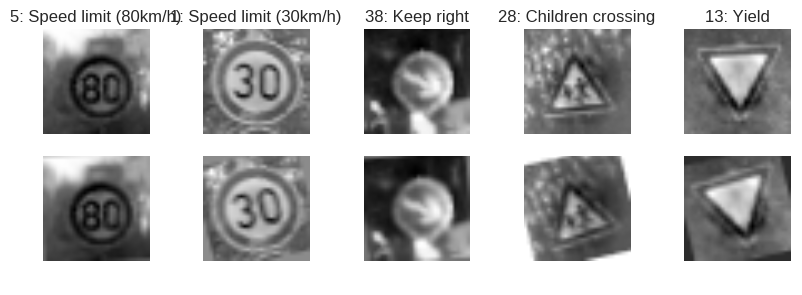

In [18]:
from skimage.transform import rotate, warp_coords
fig, axs = plt.subplots(2,5, figsize=(10, 3))
axs = axs.ravel()
plt.rc('font', size=5)
for i in range(5):
    index = random.randint(0, len(X_train))
    image = X_train_normalized[index].squeeze()
    axs[i].axis('off')
    axs[i].imshow(image, cmap='gray')
    axs[i].set_title("{}: {}".format(y_train[index], sign_lookup.loc[y_train[index]]['SignName']))
    
    image = rotate(X_train_normalized[index], angle=np.random.uniform(-15,15))
    axs[i+5].axis('off')
    axs[i+5].imshow(image, cmap='gray')

In [19]:
print("Before Generate: X={} Y={}".format(X_train_normalized.shape, y_train.shape))

Before Generate: X=(39209, 32, 32) Y=(39209,)


In [20]:
# This chunk of code on how to append result to the original one I got the idea from Jeremy Shannon's code
# https://github.com/jeremy-shannon/CarND-Traffic-Sign-Classifier-Project/blob/master/Traffic_Sign_Classifier.ipynb
class_sample_thres = 900
for _class in tqdm(need_gen):
    populations = np.where(y_train == _class)[0]
    nb_samples = len(populations)
    if nb_samples < class_sample_thres:
        for i in range(abs(nb_samples - class_sample_thres)):
            # get one from the dataset
            gen_img = X_train_normalized[populations[i % nb_samples]]
            # augment it
            gen_img = warp(rotate(gen_img, angle=np.random.uniform(-15,15)), random_shift)
            # append it to X,Y
            X_train_normalized = np.concatenate((X_train_normalized, [gen_img]), axis=0)
            y_train = np.concatenate((y_train, [_class]), axis=0)

100%|██████████| 26/26 [09:52<00:00, 30.60s/it]


In [21]:
print("After Generate: X={} Y={}".format(X_train_normalized.shape, y_train.shape))

After Generate: X=(52110, 32, 32) Y=(52110,)


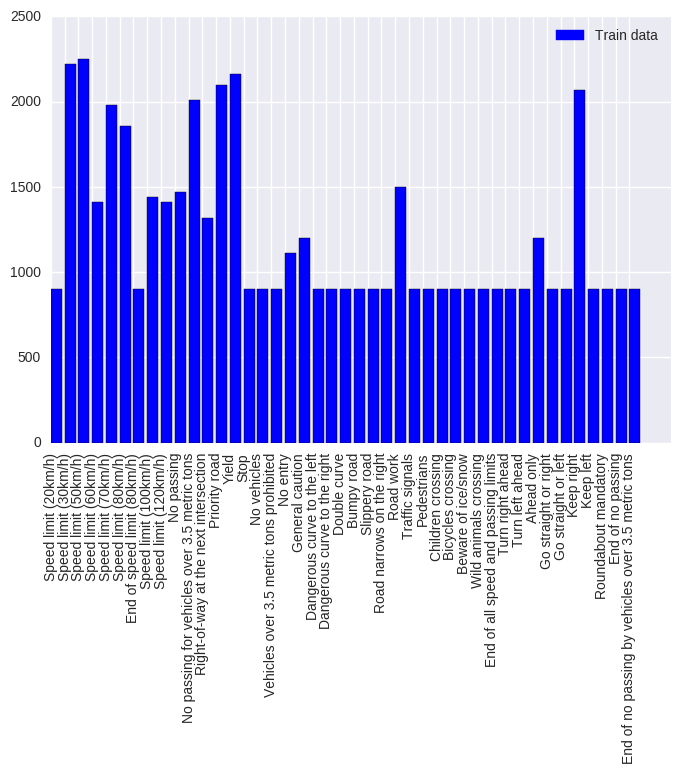

In [22]:
c = Counter(y_train)

plt.bar(list(c.keys()),list(c.values()), color='blue')
blue_patch = mpatches.Patch(color='blue', label='Train data')
plt.xticks(list(c.keys()), sign_lookup['SignName'],rotation='90')
plt.legend(handles=[blue_patch])

### Every dataset I'm shuffling

In [23]:
y_train_temp = y_train

from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(test_size=0.2)

for train_index, test_index in sss.split(X_train_normalized, y_train_temp):
    X_train, X_validation = X_train_normalized[train_index], X_train_normalized[test_index]
    y_train, y_validation = y_train_temp[train_index], y_train_temp[test_index]

(41688, 32, 32)
(10422, 32, 32)
(12630, 32, 32)


In [31]:
X_test = X_test_normalized

X_train = np.reshape(X_train,[41688,32,32,1])
X_validation = np.reshape(X_validation,[10422,32,32,1])
X_test = np.reshape(X_test_normalized,[12630,32,32,1])

print(X_train.shape)
print(X_validation.shape)
print(X_test.shape)

(41688, 32, 32, 1)
(10422, 32, 32, 1)
(12630, 32, 32, 1)


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

## TF Things

In [24]:
import tensorflow as tf

EPOCHS = 60
BATCH_SIZE = 128

In [25]:
from tensorflow.contrib.layers import flatten

def LeNetInception(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    conv1 = tf.nn.relu(conv1)

    conv2_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b

    conv2 = tf.nn.relu(conv2)
    
    conv3_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 20), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(20))
    conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b

    conv3 = tf.nn.relu(conv3)

    conv4_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 20, 28), mean = mu, stddev = sigma))
    conv4_b = tf.Variable(tf.zeros(28))
    conv4   = tf.nn.conv2d(conv3, conv4_W, strides=[1, 1, 1, 1], padding='VALID') + conv4_b

    conv4 = tf.nn.relu(conv4)
    
    conv4 = tf.nn.max_pool(conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    fc0   = flatten(conv4)
    
    fc1_W = tf.Variable(tf.truncated_normal(shape=(2800, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    
    # DROPOUT: 0.7
    fc1_drop = tf.nn.dropout(fc1, keep_prob)

    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1_drop, fc2_W) + fc2_b
    
    fc2    = tf.nn.relu(fc2)
    
    fc2_drop = tf.nn.dropout(fc2, keep_prob)

    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2_drop, fc3_W) + fc3_b
    
    return logits

In [26]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

In [27]:
rate = 0.001

logits = LeNetInception(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [28]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [32]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
from sklearn.utils import shuffle
                  
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:    
    sess.run(tf.initialize_all_variables())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.7})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.783

EPOCH 2 ...
Validation Accuracy = 0.865

EPOCH 3 ...
Validation Accuracy = 0.903

EPOCH 4 ...
Validation Accuracy = 0.919

EPOCH 5 ...
Validation Accuracy = 0.934

EPOCH 6 ...
Validation Accuracy = 0.942

EPOCH 7 ...
Validation Accuracy = 0.948

EPOCH 8 ...
Validation Accuracy = 0.952

EPOCH 9 ...
Validation Accuracy = 0.956

EPOCH 10 ...
Validation Accuracy = 0.962

EPOCH 11 ...
Validation Accuracy = 0.964

EPOCH 12 ...
Validation Accuracy = 0.965

EPOCH 13 ...
Validation Accuracy = 0.967

EPOCH 14 ...
Validation Accuracy = 0.971

EPOCH 15 ...
Validation Accuracy = 0.970

EPOCH 16 ...
Validation Accuracy = 0.972

EPOCH 17 ...
Validation Accuracy = 0.975

EPOCH 18 ...
Validation Accuracy = 0.975

EPOCH 19 ...
Validation Accuracy = 0.975

EPOCH 20 ...
Validation Accuracy = 0.975

EPOCH 21 ...
Validation Accuracy = 0.975

EPOCH 22 ...
Validation Accuracy = 0.978

EPOCH 23 ...
Validation Accuracy = 0.978

EPOCH 24 ...
Validation Accura

Log

- 20epoch GrayScale + Zscore, Lenet architecture validation_acc = 0.979, test = 0.882
- 60epoch GrayScale + Zscore, 3x3 3x3 5x5 5x5 maxpool architecture validation_acc = 0.996, test = 0.968
- 60epoch GrayScale + histeq + Zscore + data generation(rotate,warp) validation_acc = 0.986, test = 0.971

In [33]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(tf.initialize_all_variables())
    saver2 = tf.train.import_meta_graph('./lenet.meta')
    saver2.restore(sess, "./lenet")
    test_accuracy = evaluate(X_test, y_test)
    print("Test Set Accuracy = {:.3f}".format(test_accuracy))

Test Set Accuracy = 0.971


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

**Data Preprocessing**
 - rgb to grayscale, my perception is that the Traffic sign should reproduce the same meaning even it is in grayscale, and thus should cover the same procedure because the convnet is trying to mimic human's eyes
 - Histrogram equalization on the images to make sure that the images are not too bright or too dark 
 - i Normalize the data using zscore to prevent gradients explode

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

**Train/Validate/Test Splitting**
 - I use StratifiedShuffleSplit for splitting dataset for train/validate as mentioned from the suggestions. I use test_size=0.2
 
**Data Generation**
 - How Did I generate data
  - I generate the data from original dataset by
   - rotate the images by ±15°
   - translate(move) the images up down left right by ±5 pixels
 - Why Did I generate data
  - The numbers of data classes are imbalanced, so I try to generate them which prevents the problems when training the network
 - The differences from original dataset
  - we got almost balanced dataset for most classes, it's not that balanced, but at least it's much better then before

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

### Improvement
In order to further improve this work, it would be better to visualize the architecture that is adopted. And TensorBoard is a very good visualization tool. I will add the screenshot from the board soon :)

My architecture is as the following

1. 6@3x3 convolution
1. 16@3x3 convolution
1. 20@5x5 convolution
1. 28@5x5 convolution
1. 2x2 maxpooling
1. 3 FC layers
1. (2800, 120)
1. Dropout keep_prob = 0.7
1. (120, 84)
1. Dropout keep_prob = 0.7
1. (84, 43)

Note that I did not use the maxpooling between convolutional layers, becuase I feel that making convolution to get all the features might be more useful & be able to extract more features even it is more computational expensive

The main reason I use dropout is because [this](Dropout: A Simple Way to Prevent Neural Networks from Overfitting) paper states that using dropout a network can be able to prevent complex co-adaptation, and I gives higher test accuracy :)

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
-------
In summary,

1. EPOCHS = 60
1. BATCHSIZE = 128
1. learning_rate = 0.001
1. keep_prob =0.7
1. AdamOptimizer


Mostly are the same, all i added is just to train for more epochs, at first i am scared that it might lead to overfitting. but I got dropout, so at least it could prevent it. I train module vary the keep_prob from 0.5 0.6 0.7 and I found that 0.7 gives me the best value

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

Mostly Trial and error

 - I use AdamOptimizer because it is like Stochastic Gradient Descent with smaller memory requirement and provides adaptive learning rate, According to ADAM: A method for stochastic optimization. 
 - I chose the type of layer under the perception that trying to vary the size of convolutional kernel from small to big is the right thing to do because the small kernel it would track the abstraction which might be features of a particular class and the bigger kernel might extract the high level feature
 - there are 5 hyperparameters I need to tune which are EPOCHS, BATCHSIZE, learning_rate and dropout keep_prob
  - for the first 4 I try to do all combinations of them and see which one gives the best result
  - then, I try to vary the value of keep_prob based on how it does well on the test set
 - I tested the dataset with vanilla lenet, but it does not generalize well on the test&my dataset, so I believe the network lacks of some data. That's why I try to generate more dataset and preprocess them according to my sense that the images can be rotate and transform according to the raw data
 - I fine-tuned the model upon how well the model works on validation set, does it converges too fast? or too slow, once the model can proceed train well, I finalize the result based on benchmark it on the accuracy of test set. I also check that the result of training and testing dataset should not be too far, or it might cause overfitting


---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [36]:
images

['my-images/caution.png',
 'my-images/bike.png',
 'my-images/ahead.png',
 'my-images/stop.png',
 'my-images/camel.png',
 'my-images/cattle.png']

/usr/lib/python3/dist-packages/scipy/stats/stats.py:2095: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


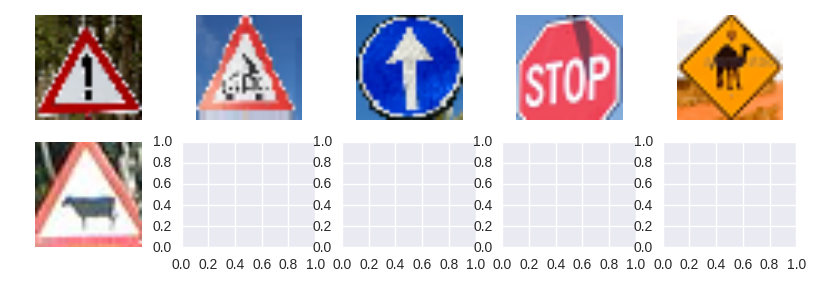

In [73]:
from glob import glob 
import matplotlib.image as mpimg

images = glob('my-images/*.png')
fig, axs = plt.subplots(2,5, figsize=(10, 3))
axs = axs.ravel()
new_imgs = []
for idx,img_path in enumerate(images):
    img = mpimg.imread(img_path)
    new_img_gray = rgb2gray(img)
    new_img_sq_simple = image_histogram_equalization(new_img_gray)[0]
    new_img = stats.zscore(new_img_sq_simple)
    new_imgs.append(new_img)
    axs[idx].axis('off')
    axs[idx].imshow(img, cmap='gray')

In [74]:
y_new_imgs = [18,29,35,14,31,31]

In [75]:
new_imgs = np.asarray(new_imgs)
new_imgs_nonreshape = new_imgs
new_imgs = np.reshape(new_imgs,[6,32,32,1])
new_imgs.shape

(6, 32, 32, 1)

In [82]:
new_imgs_nonreshape[0][:50]

array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])

/usr/local/lib/python3.4/dist-packages/numpy/ma/core.py:4185: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


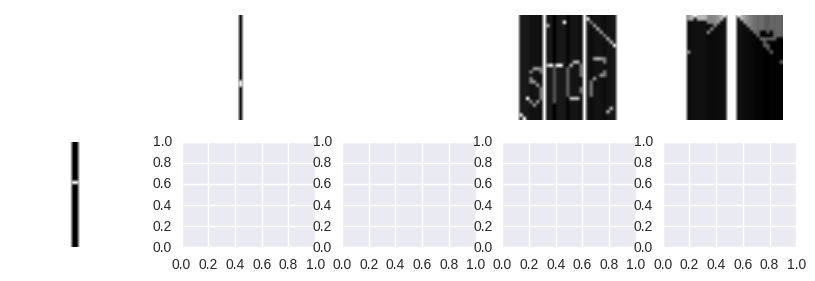

In [77]:
fig, axs = plt.subplots(2,5, figsize=(10, 3))
axs = axs.ravel()
for idx,img in enumerate(new_imgs_nonreshape):
    axs[idx].axis('off')
    axs[idx].imshow(img, cmap='gray')

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

There are general cases where the images are hard to classified which are
 - The Brightness, the image may be too dark to perceive information from them
 - The Contrast, the image might lack of contrast to extract detail
 - The Angle, for some sign, the rotation causes confusion to the network and human
 
the images are on the above cells, I find difficulties for most images i chose
 - 1st image, nothing is wrong, the network should be able to classify this
 - 2nd image, the bicycle crossing one, I think it is hard to classify since the data is downsampling poorly by paint which can't even connect the wheel, and there is a person on the sign which is not exact the same as we have in dataset
 - 3rd image, the go ahead, the network should be able to classify this
 - 4th image, the stop, if my network learn to detect the "STOP" font, it should be able to classify this easily, however since the network might pick up the 6 corner shape(pentagon?) and the lower part of the image is cut, it might create problem with the classifier
 - 5th & 6th image, the wildlife ones, I'm not sure if we have enough data to train with different species with the network, both two surely break the network :D

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


In [41]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(tf.initialize_all_variables())
    saver3 = tf.train.import_meta_graph('./lenet.meta')
    saver3.restore(sess, "./lenet")
    new_accuracy = evaluate(new_imgs, y_new_imgs)
    print("Test Set Accuracy = {:.3f}".format(new_accuracy))

Test Set Accuracy = 0.167


**Answer:**
**Only 1 of 6 is correctly classified :(**

My model is too weak to generalize and localize the street sign I found on Google :D. The Accuracy on my acquired images is quite low at only **16.7%** while it was **97.1%** on the testing set. I believe the reason can be found in the answer to the question 6 or the model might be overfitting in the sense of it lacks variety of data (camels,cows)

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**
For the centainty of predictions, the model is certain and correctly predicted only the one obvious sign which is Go Ahead only (3rd image). However, when it comes to other signs, the network is too far to be correct for these images. I believe the reason is explained on the answer to question 6. There is a case which is the 1st image(General Caution) that its class appears on the top_k predictions, but the softmax probability is too little to be correct :D, and I hope it was obvious and could be predicted correctly. Maybe, it was because I didn't downsampling it nicely.

In [46]:
softmax_logits = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax_logits, k=3)
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(tf.initialize_all_variables())
    saver4 = tf.train.import_meta_graph('./lenet.meta')
    saver4.restore(sess, "./lenet")
    new_softmax_logits = sess.run(softmax_logits, feed_dict={x: new_imgs, keep_prob: 1.0})
    top_predictions = sess.run(top_k, feed_dict={x: new_imgs, keep_prob: 1.0})

In [48]:
top_predictions.indices
candidates = new_imgs

In [66]:
np.reshape(candidate,(32,32))

array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])

/usr/local/lib/python3.4/dist-packages/numpy/ma/core.py:4185: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


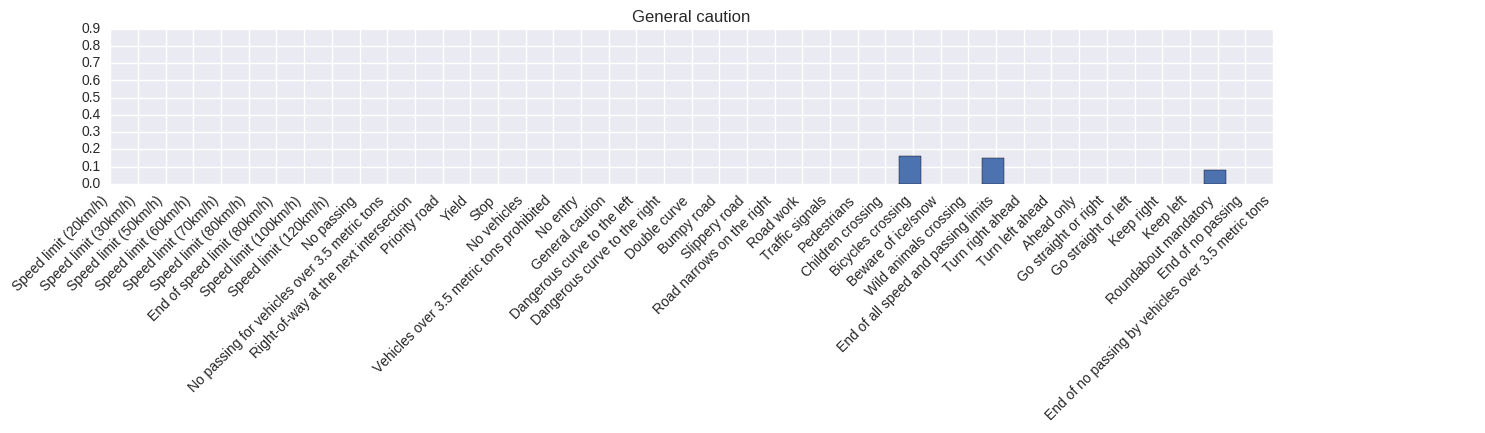

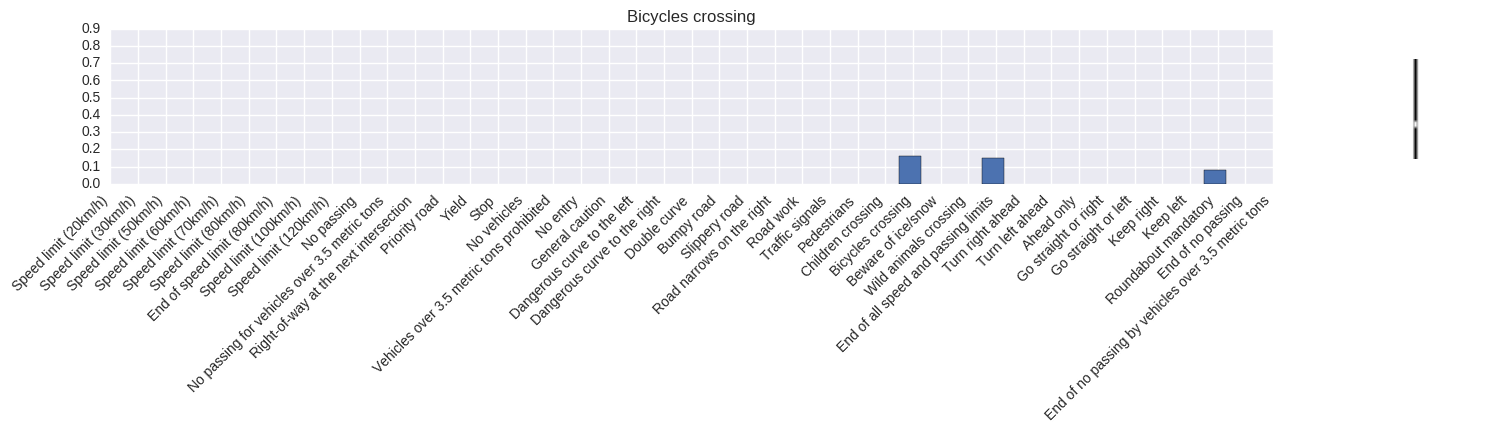

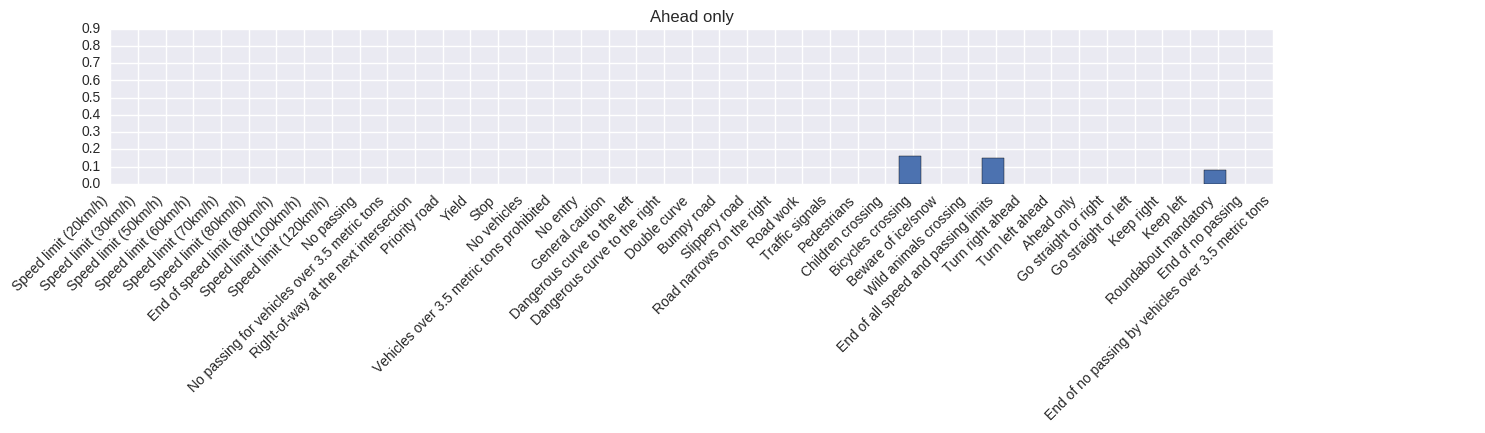

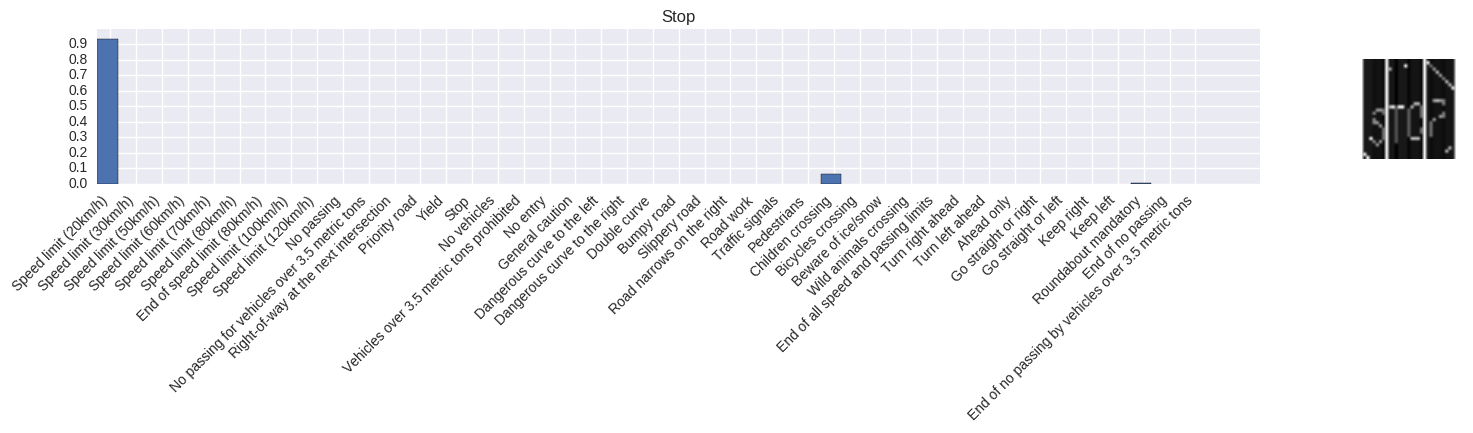

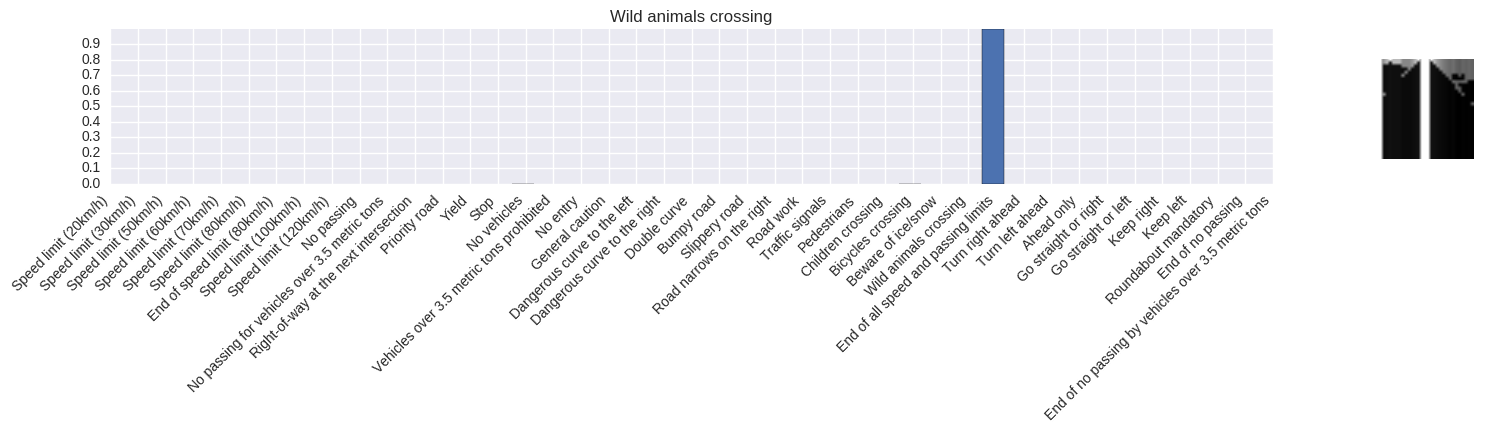

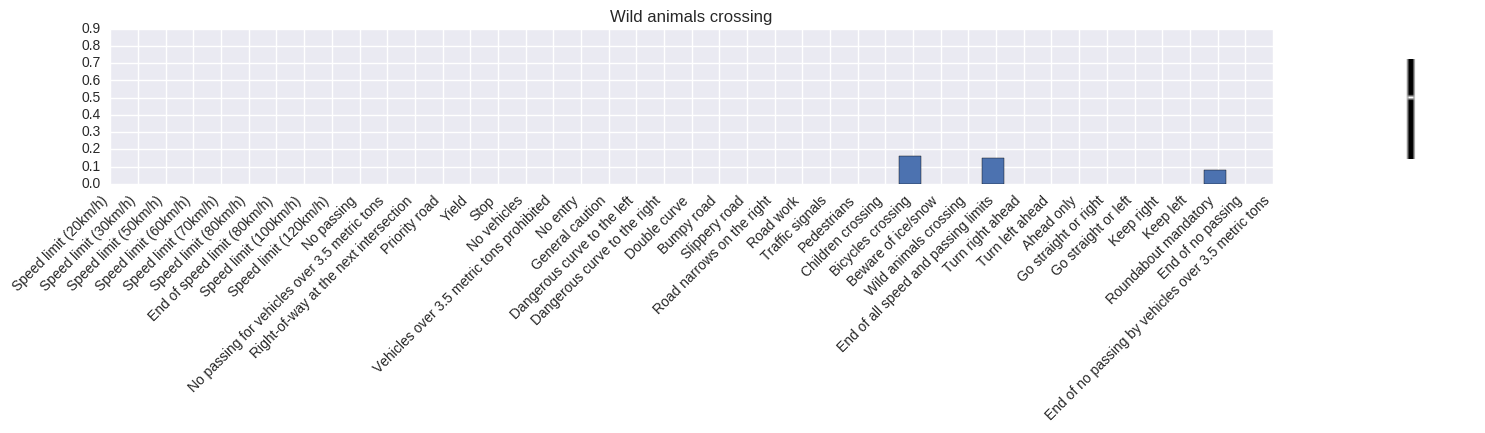

In [69]:
# I took code from the suggestions
for i,(labels,probs,candidate) in enumerate(zip(top_predictions.indices, top_predictions.values, candidates)):
    fig = plt.figure(figsize=(15,2))
    plt.bar(labels,probs)
    plt.title(sign_lookup.loc[y_new_imgs[i]]['SignName'])
    height = candidate.shape[0]
    plt.xticks(np.arange(0.5, 43.5, 1.0), sign_lookup['SignName'].values, ha='right', rotation=45)
    plt.yticks(np.arange(0.0, 1.0, 0.1), np.arange(0.0,1.0,0.1))
    
    ax = plt.axes([.75, 0.25, 0.5, 0.5], frameon=True)
    ax.imshow(candidate.squeeze(), cmap='gray')
    ax.axis('off')
    
plt.show()
    

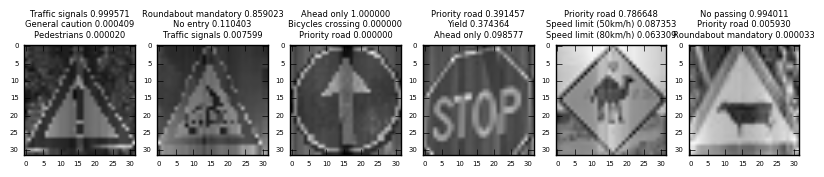

In [128]:
softmax_logits = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax_logits, k=3)

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(tf.initialize_all_variables())
    saver4 = tf.train.import_meta_graph('./lenet.meta')
    saver4.restore(sess, "./lenet")
    new_softmax_logits = sess.run(softmax_logits, feed_dict={x: new_imgs, keep_prob: 1.0})
    new_top_k = sess.run(top_k, feed_dict={x: new_imgs, keep_prob: 1.0})
    
    fig, axs = plt.subplots(1,6, figsize=(10, 3))
    for idx,img in enumerate(new_imgs):
        probs = [(i[1],i[0]) for i in sorted(enumerate(new_softmax_logits[idx]), 
                                             key=lambda x:x[1], reverse=True)][:3]
        axs[idx].imshow(img[:,:,0], cmap='gray')
        axs[idx].set_title("{} {:2f}\n{} {:2f}\n{} {:2f}".format(
                sign_lookup.loc[probs[0][1]]['SignName'], probs[0][0],
                sign_lookup.loc[probs[1][1]]['SignName'], probs[1][0],
                sign_lookup.loc[probs[2][1]]['SignName'], probs[2][0]))

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.